# Get a LSST Simulated Cadence for Arbitrary Sky Position
___


___

In [1]:
"""

"""
%matplotlib inline
# %matplotlib notebook

from __future__ import print_function

try:
    from importlib import reload
except:
    pass


from matplotlib import pyplot as plt
import matplotlib.colors as mpl_colors 

import os
import sys
import warnings

import numpy as np
import pandas as pd
import astropy as ap
import sfdmap

import sqlite3
from sqlalchemy import create_engine

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table

import lsst_tools.utils as utils 
import lsst_tools.utils.colours as colours 

import pyCoCo as pccsims
import pycoco as pcc

Connect to .db file that contains the opsim output, read into a dataframe, `opsimdf`

In [2]:
# %%timeit ## 1 loop, best of 3: 1min 31s per loop 
opsimdbpath = os.environ.get('OPSIMDBPATH')
print(opsimdbpath)
# opsimdbpath = "/Users/berto/data/LSST/OpSimOutputDBs/astro_lsst_01_1068_sqlite.db"
opsimdbpath = "/Users/berto/data/LSST/OpSimOutputDBs/minion_1016_sqlite.db"

conn = create_engine('sqlite:///'+opsimdbpath, echo = False)
opsimdf = pd.read_sql_table('Summary', con=conn)

/Users/berto/data/LSST/OpSimOutputDBs/Pitt16/minion_1016_sqlite.db


Check that the db looks as we expect

In [3]:
opsimdf.head()

,obsHistID,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,...,moonBright,darkBright,rawSeeing,wind,humidity,slewDist,slewTime,fiveSigmaDepth,ditheredRA,ditheredDec
0,1,1016,54,316,1.676483,-1.082473,y,2922,59580.033829,0,...,0.0,105.610378,0.920473,0.0,0.0,1.620307,0.000000,21.021236,1.643930,-1.108924
1,2,1016,54,372,1.694120,-1.033972,y,2961,59580.034275,0,...,0.0,105.167017,0.920473,0.0,0.0,0.049266,4.574944,21.026646,1.664257,-1.060423
2,3,1016,54,441,1.708513,-0.985271,y,2999,59580.034722,0,...,0.0,104.849578,0.920473,0.0,0.0,0.049298,4.595615,21.030520,1.680878,-1.011722
3,4,1016,54,505,1.720374,-0.936476,y,3038,59580.035169,0,...,0.0,104.669398,0.920473,0.0,0.0,0.049266,4.605366,21.032718,1.694604,-0.962927
4,5,1016,54,587,1.730248,-0.887672,y,3077,59580.035616,0,...,0.0,104.627207,0.920473,0.0,0.0,0.049177,4.604023,21.033233,1.706054,-0.914123


Connecting to `.db` takes ages (~1min), and is a pain if you mess up, so create a 'working' instance to fiddle with

In [4]:
working_df = opsimdf

In [5]:
working_df = utils.find_MW_extinction(working_df)

## Choosing Position and Identifying Fields
___

Use **`lsst_tools.utils.generate_coordinates()`** to give us a position 


In [6]:
#%%timeit ## The slowest run took 39.04 times longer than the fastest. This could mean that an intermediate result is being cached.
#         ## 1000 loops, best of 3: 246 µs per loop
n = 1
pos_df = utils.generate_coordinates(n)
print(pos_df)
# pos_df["phi"] = -0.122
# pos_df["theta"] = 0.0

        phi     theta
0  0.039116  2.330231


Check the positions are sensible

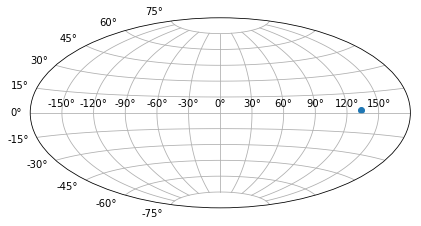

In [7]:
#%%timeit ## 1 loop, best of 3: 235 ms per loop
utils.plot_position_points(pos_df)

We want to find out which field(s) the position is in. Create table that tells us the field centres, and find the edges.

In [8]:
# working_df = utils.get_field_corners(working_df.drop_duplicates("fieldID"))[['fieldRA', 'fieldDec']]
allfields_df = utils.get_field_corners(pd.DataFrame(working_df.drop_duplicates("fieldID"))[['fieldID', 'fieldRA', 'fieldDec']])

In [9]:
allfields_df.head()

,fieldID,fieldRA,fieldDec,RA_upper,RA_lower,Dec_upper,Dec_lower
0,316,1.676483,-1.082473,1.707026,1.645940,-1.113016,-1.051930
1,372,1.694120,-1.033972,1.724663,1.663577,-1.064515,-1.003429
2,441,1.708513,-0.985271,1.739056,1.677970,-1.015814,-0.954728
3,505,1.720374,-0.936476,1.750917,1.689831,-0.967019,-0.905933
4,587,1.730248,-0.887672,1.760791,1.699705,-0.918215,-0.857129


In [10]:
field_df = allfields_df[(allfields_df["RA_upper"] >= pos_df["theta"][0] + np.pi) &
                (allfields_df["RA_lower"] <= pos_df["theta"][0] + np.pi) &
                (allfields_df["Dec_lower"] >= pos_df["phi"][0])  &
                (allfields_df["Dec_upper"] <= pos_df["phi"][0])]

This narrows down the fields in which our position appears:

In [11]:
field_df

,fieldID,fieldRA,fieldDec,RA_upper,RA_lower,Dec_upper,Dec_lower
114505,2735,5.490756,0.03409,5.521299,5.460213,0.003547,0.064633


### Deep Drilling Fields:
___

* minion2016: 1427,744,2412,290,2786
* astro_lsst_01_1068: 1427,744,2412,290,2786
* Fake_Rolling: 290,2786


In [12]:
opsimdf.loc[opsimdf["fieldID"] == 505].head() ## WFD

,obsHistID,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,...,darkBright,rawSeeing,wind,humidity,slewDist,slewTime,fiveSigmaDepth,ditheredRA,ditheredDec,EBV_MW
3,4,1016,54,505,1.720374,-0.936476,y,3038,59580.035169,0,...,104.669398,0.920473,0.0,0.0,0.049266,4.605366,21.032718,1.694604,-0.962927,0.073125
736,737,1016,54,505,1.720374,-0.936476,z,89952,59581.041121,1,...,102.261170,0.701202,0.0,0.0,0.053899,4.752482,21.760884,1.701047,-0.962927,0.073125
760,761,1016,54,505,1.720374,-0.936476,z,90898,59581.052066,1,...,99.499712,0.729082,0.0,0.0,0.087567,6.236553,21.759073,1.701047,-0.962927,0.073125
1482,1483,1016,54,505,1.720374,-0.936476,z,176788,59582.046159,2,...,100.267993,0.826179,0.0,0.0,0.053899,4.727801,21.650976,1.707489,-0.962927,0.073125
15455,15455,1016,54,505,1.720374,-0.936476,r,1820874,59601.074933,21,...,87.151631,0.741071,0.0,0.0,0.049177,5.204940,23.957933,1.701047,-0.956314,0.073125


In [13]:
opsimdf.loc[opsimdf["fieldID"] == 1427].head() ## DDF

,obsHistID,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,...,darkBright,rawSeeing,wind,humidity,slewDist,slewTime,fiveSigmaDepth,ditheredRA,ditheredDec,EBV_MW
229,230,1016,56,1427,0.925184,-0.4789,r,12057,59580.139555,0,...,84.646287,0.866285,0.0,0.0,0.755889,140.0,24.070428,0.907976,-0.505351,0.007715
230,231,1016,56,1427,0.925184,-0.4789,r,12093,59580.139972,0,...,84.969264,0.791241,0.0,0.0,0.000000,2.0,24.143180,0.907976,-0.505351,0.007715
231,232,1016,56,1427,0.925184,-0.4789,r,12129,59580.140389,0,...,85.037385,0.791241,0.0,0.0,0.000000,2.0,24.141983,0.907976,-0.505351,0.007715
232,233,1016,56,1427,0.925184,-0.4789,r,12165,59580.140805,0,...,85.105955,0.859965,0.0,0.0,0.000000,2.0,24.068792,0.907976,-0.505351,0.007715
233,234,1016,56,1427,0.925184,-0.4789,r,12201,59580.141222,0,...,85.174974,0.859965,0.0,0.0,0.000000,2.0,24.067582,0.907976,-0.505351,0.007715


In [31]:
# reload(pccsims)

<module 'pyCoCo' from '/Users/berto/Code/CoCo/pyCoCo.cpython-36m-darwin.so'>

## Extinction

Get the Milky Way extinction along the line of site towards the SNe. The working_df contains the EBV_MW at the field centre, but we can do better than that, by using the position of the SN itself.

In [14]:
working_df["EBV_MW"][working_df["fieldID"].isin(working_df["fieldID"].values)].values

array([ 0.04527743,  0.04593042,  0.08043004, ...,  0.05865358,
        0.06319557,  0.05767386])

In [15]:
pos_df

,phi,theta
0,0.039116,2.330231


In [16]:
# %%timeit ## 1 loop, best of 3: 88.6 ms per loop
pos_df = utils.find_MW_extinction(pos_df) 

extinction = pos_df["EBV_MW"].values[0]
print(extinction)

0.0320268438741


In [28]:
# filter_path = "/Users/berto/Code/CoCo/data/filters"
filter_path = pcc._default_filter_dir_path
# coco_root_path = "/Users/berto/Code/CoCo"
coco_root_path = pcc._default_coco_dir_path 

coco = pccsims.pyCoCo(utils.b(filter_path), utils.b(coco_root_path))

inputs:

* **`snname`**
* **`redshift`**
* **`absmag offset`**
* **`EBV MW`**
* **`EBV Host`**
* **`Rv`**
* **`MJD at Peak`**

* **`MJD to simulate`**
* **`filters to simulate`**

In [18]:
z_obs = 0.007
# z_obs = 0.1
# z_obs = 0.2
host_EBV = 0.2
MW_EBV = extinction
# mjdmax = 60307.314753999999
# mjdmax = 59580 + 1.* 365. ## DDF 2786
# mjdmax = 59580 + 1.5* 365. ## WFD 550
mjdmax = 59580 + 1.3* 365. ## WFD 2297

In [19]:
mjd_to_sim = working_df["expMJD"][working_df["fieldID"].isin(field_df["fieldID"].values)].values
limiting_mags = working_df["fiveSigmaDepth"][working_df["fieldID"].isin(field_df["fieldID"].values)].values

filters_to_sim = working_df["filter"][working_df["fieldID"].isin(field_df["fieldID"].values)].values
filters_to_sim = np.array([utils.b('LSST_'+x) for x in filters_to_sim])

In [20]:
# mjd_to_sim = np.array([90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 105.0, 110.0, 115.0, 120.0])
# filters_to_sim = np.array([b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r'])
# mjd_to_sim = 
# filters_to_sim = 

print(mjdmax)
print(mjd_to_sim)
print(filters_to_sim)

60054.5
[ 59722.314185  59722.335862  59728.328403  59752.224898  59752.238567
  59769.175502  59769.193999  59772.16638   59772.172194  59772.178458
  59772.182929  59772.185608  59772.201317  59777.163095  59777.234212
  59777.251703  59777.265758  59790.145979  59793.170172  59793.195334
  59797.094122  59797.110631  59799.098988  59806.092035  59806.103821
  59807.127253  59807.149978  59808.128101  59808.143783  59808.155678
  59808.171514  59810.071874  59810.089464  59818.061555  59826.083873
  59826.102798  59836.007736  59836.030663  59836.99475   59838.978423
  59838.993323  59839.011172  59840.981435  59840.98501   59840.990382
  59840.995745  59843.981718  59843.995217  59849.982851  59849.996815
  59859.023388  59859.03567   59869.072208  59869.087201  59877.040436
  59878.060389  60046.417645  60046.420328  60051.408061  60051.416551
  60055.400085  60056.396723  60057.396997  60059.415353  60061.416077
  60062.372767  60062.386509  60062.415514  60064.389447  60064.40557

In [21]:
# plt.scatter(mjd_to_sim, np.ones(len(mjd_to_sim)))
# plt.scatter([mjdmax], [1])

In [22]:
# filters_to_sim = np.array([i.replace(utils.b("LSST"), utils.b("SDSS")) for i in filters_to_sim])

In [29]:
# flux, flux_err = coco.simulate(b"SN2007uy", 
#                     z_obs, 0.0, MW_EBV, host_EBV, 3.1, 
#                     mjdmax, mjd_to_sim, 
#                     filters_to_sim)
snname = b"SN2007uy"
# snname = b"SN2009jf"
flux, flux_err = coco.simulate(snname, 
                    z_obs, 0.0, MW_EBV, host_EBV, 3.1, 
                    mjdmax, mjd_to_sim, 
                    filters_to_sim)
# flux, flux_err = coco.simulate(b"SN2009jf", 
#                     z_obs, 0.0, 0.1, 0.1, 3.1, 
#                     mjdmax, mjd_to_sim, 
#                     filters_to_sim)

In [30]:
flux, flux_err

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [25]:
print(np.nanmax(flux))

0.0


In [ ]:
reload(pcc.classes)

In [ ]:
p = pcc.PhotometryClass()
phot_table = pcc.utils.simulate_out_to_ap_table(mjd_to_sim, flux, flux_err, filters_to_sim)
phot_table = phot_table[np.where(phot_table["flux"] > 1e-20)]
p.load_table(phot_table)

In [ ]:
p.plot(xlim = [59950, 60100])

In [ ]:
p.data

In [ ]:
t = pcc.utils.simulate_out_to_ap_table(mjd_to_sim, flux, flux_err, filters_to_sim)

In [ ]:
t[np.logical_and(t["filter"] != "SDSS_y", t["filter"]!= "SDSS_z")]

In [ ]:
p = pcc.PhotometryClass()
pt = pcc.utils.simulate_out_to_ap_table(mjd_to_sim, flux, flux_err, filters_to_sim)
pt_lim_m = pt
pt_lim_m["fivesigmadepth"] = limiting_mags

In [ ]:
pt = pt_lim_m[np.where(pt_lim_m["flux"] > 1e-22)]

In [ ]:
pt

In [ ]:
days_before = 40
days_after = 100
print(mjdmax)
w = np.where(np.logical_and(pt["MJD"] > mjdmax - days_before, pt["MJD"] < mjdmax + days_after))
print(w)
pt[w]

In [ ]:
print(snname)
print(chosenfield)
print(z_obs)
print(extinction)
print(opsimdbpath)
print(mjdmax)

In [ ]:
reload(pcc)
reload(pcc.classes)
# reload(pcc.utils)

In [ ]:
p.load_table(pt[w], verbose= True)


p.plot()

In [ ]:
p.unpack(verbose = True)

In [ ]:
phot_table = p.phot.loc["filter", "LSST_u"]

In [ ]:
phot_table

In [ ]:
phot_table.meta["filter_filename"] = "foo"

In [ ]:
pt[w]

In [ ]:
# filter_file_type = '.dat'
# filter_names = np.unique(pt[w]["filter"])
# print(filter_names)
# pt.add_index('filter', unique = True)
# for filter_name in filter_names:
# #     phot_table = self.phot.loc["filter", filter_name]
#     filter_filename = filter_name + filter_file_type
#     print(filter_filename)

In [ ]:
# reload(pcc)
# phot = pcc.PhotometryClass()
# infile = "/Users/berto/projects/LSST/cadence/lightcurves/SNSim_0002_minion_1016_SN2007uy_z=02_EBVMW=0029_EBVHOST=01_fieldID=2297WFD.dat"
# phot.load(path = infile, names = ("MJD", "flux", "flux_err", "filter", "fivesigmadepth"), verbose = True)
# # phot.load_phot_from_file(path = infile, format = "ascii.commented_header")

# phot.unpack(verbose = True)

In [ ]:
# phot.data

In [ ]:
# phot_table = Table.read(infile, names = ("MJD", "flux", "flux_err", "filter", "fivesigmadepth"), format = "ascii")

In [ ]:
# phot_table.meta["filename"] = infile

# phot_table["MJD"].unit = u.day
# phot_table["flux"].unit = u.cgs.erg / u.si.angstrom / u.si.cm ** 2 / u.si.s
# phot_table["flux_err"].unit =  phot_table["flux"].unit

In [ ]:
# reload(pcc)
# p = pcc.PhotometryClass()
# p.load_table(phot_table, verbose = True)